In [1]:
# Importing Libraries
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy
import pandas as pd
import statistics
import time
from tqdm import tqdm
%matplotlib inline

                                             Property Annotation        Value
0                               Porosity in fraction:        phi     0.500000
1                             Reservoir Length in ft:          L  1000.000000
2                             Reservoir Height in ft:          H    10.000000
3                                    Viscosity in cp:         mu     0.800000
4                    Total Compressibility in psi^-1:         Ct     0.000005
5            Fluid Formation Volume Factor in rb/stb:         Bo     1.100000
6                                  Time Step in days:      Del_t     0.003000
7                               Number of Time Steps:         Nt   400.000000
8                Number of Blocks in both directions:          N    11.000000
9                   Reservoir Pressure in psi at t=0:         Pi  2000.000000
10  Surface flow rate at center of reservoir in st...        qsc   100.000000


    Permeability in md at Cell location     1    2   3   4    



Red => Time Step= 40
Yellow => Time Step= 200
Magenta => Time Step= 400


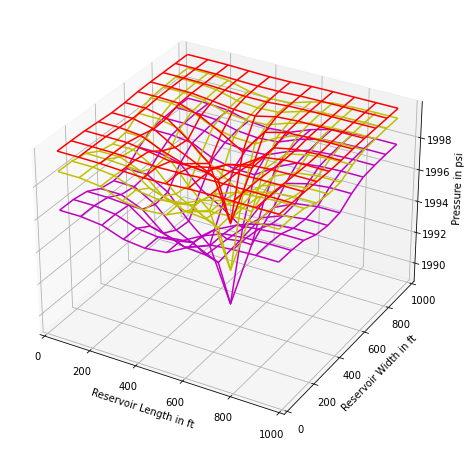

In [2]:
# input reservoir data and permeability for any odd number of blocks
xls = pd.ExcelFile('Data_2D_Heterog.xlsx')
Reservoir_data = pd.read_excel(xls, 'Sheet1')
perm = pd.read_excel(xls, 'Sheet2')
print(Reservoir_data)
print("\n")
print(perm)
phi=np.float64(Reservoir_data['Value'][0])
L=np.float64(Reservoir_data['Value'][1])
W=np.float64(Reservoir_data['Value'][1])
H=np.float64(Reservoir_data['Value'][2])
mu=np.float64(Reservoir_data['Value'][3])
Ct=np.float64(Reservoir_data['Value'][4])
Bo=np.float64(Reservoir_data['Value'][5])
Del_t=np.float64(Reservoir_data['Value'][6])
Nt=int(Reservoir_data['Value'][7])
N=int(Reservoir_data['Value'][8])
Del_x=L/N
print("\nSize of Block: ", Del_x, "ft")
Pi=float(Reservoir_data['Value'][9]) # input Initial condition: reservoir pressure at t=0
qsc=float(Reservoir_data['Value'][10]) # input surface flow rate for the production well at center block
print("\nIC \n at t=0, Reservoir Pressure is ", Pi, " psi \nBCs \n Surface production rate at the centre block, i.e. (",(N+1)/2,",",(N+1)/2,") is ", qsc, "stb/day \n at the reservoir boundaries (NEUMANN BC), NO  FLOW is there i.e., (Del_P/Del_x)=0\n")
Psc=5.615*Bo*Del_t*qsc/W/H/Del_x/phi/Ct
k=np.zeros((N,N))
for i in range(N):
    for j in range(N):
        k[i,j]=np.float64(perm[j+1][i])
print(k)
k50=statistics.mean(k.flatten())
k84=statistics.stdev(k.flatten())
V=k84/k50  # Dykstra-Parsons Hetergeneity coefficient
print("\nEstimation of Dykstra-Parsons Heterogeneity Coefficient:\nFrom the given Permeability data, K50 = ",k50," md and K84.1 = ",k84, " md \nSo, V = (k50-k84)/k50 = ",V)
eta=np.zeros((N,N))
for i in range(N):
    for j in range(N):
        eta[i,j]=np.float64(0.00633*k[i,j]*Del_t/phi/mu/Ct/(Del_x**2))
print(eta)
print("\n")

# Estimation of Interblock k and eta values along x- and y-directions
print("Estimation of InterBlock k and eta Values:")
kxib=np.zeros((N,N-1))
for i in range(N):
    for j in range(N-1):
        kxib[i,j]=np.float64(2/((1/k[i,j])+(1/k[i,j+1]))) # Harmonic Average for flow media in series # x-direction
kyib=np.zeros((N-1,N))
for i in range(N-1):
    for j in range(N):
        kyib[i,j]=np.float64(2/((1/k[i,j])+(1/k[i+1,j]))) # y-direction
print("Interblock k-")
print("in x-direction-")
print(kxib)
print("in y-direction-")
print(kyib)
print("Interblock eta-")
etaxib=0.00633*kxib*Del_t/phi/mu/Ct/(Del_x**2) # x-direction
etayib=0.00633*kyib*Del_t/phi/mu/Ct/(Del_x**2) # y-direction
print("in x-direction-")
print(etaxib)
print("in y-direction-")
print(etayib)

# Stability Criteria
print("Checking for Stability Criteria of eta < 0.5 for Explicit Method:")
print("For each Block eta:")
for i in range(N):
    for j in range(N):
        if eta[i,j]<0.5:
            print("For Block Address ("+str(i+1)+","+str(j+1)+") ==> Satisfied!")
        else:
            print("Stability criteria not met \n Input NEW VALUES for Time Step and Number of Blocks")
print("For InterBlock eta:")
print("in x-direction-")
for i in range(N):
    for j in range(N-1):
        if etaxib[i,j]<0.5:
            print("Between Block Address ("+str(i+1)+","+str(j+1)+") and ("+str(i+1)+","+str(j+2)+") ==> Satisfied!")
        else:
            print("Stability criteria not met \n Input NEW VALUES for Time Step and Number of Blocks")
print("in y-direction-")
for i in range(N-1):
    for j in range(N):
        if etayib[i,j]<0.5:
            print("Between Block Address ("+str(i+1)+","+str(j+1)+") and ("+str(i+2)+","+str(j+1)+") ==> Satisfied!")
        else:
            print("Stability criteria not met \n Input NEW VALUES for Time Step and Number of Blocks")
            
# Generating pressure responses
P=np.full((Nt+1,N,N),Pi,dtype=np.float64)
for l in range(1,Nt+1):
    for i in range(1,N-1):
        for j in range(1,N-1):
            
            if i==(N-1)/2 and j==(N-1)/2:
                P[l,i,j]=-Psc+etaxib[i,j-1]*P[l-1,i,j-1]+etaxib[i,j]*P[l-1,i,j+1]+(1-(etaxib[i,j-1]+etaxib[i,j]+etayib[i-1,j]+etayib[i,j]))*P[l-1,i,j]+etayib[i-1,j]*P[l-1,i-1,j]+etayib[i,j]*P[l-1,i+1,j]
            else:
                P[l,i,j]=etaxib[i,j-1]*P[l-1,i,j-1]+etaxib[i,j]*P[l-1,i,j+1]+(1-(etaxib[i,j-1]+etaxib[i,j]+etayib[i-1,j]+etayib[i,j]))*P[l-1,i,j]+etayib[i-1,j]*P[l-1,i-1,j]+etayib[i,j]*P[l-1,i+1,j]
    # Neumann BC
    P[l,0,:]=P[l,1,:]
    P[l,-1,:]=P[l,-2,:]
    P[l,:,0]=P[l,:,1]
    P[l,:,-1]=P[l,:,-2]

print("\n")
m=[]
for i in range(N):
    m.append((i+0.5)*Del_x)
    
# Plotting 3D surface of pressure responses for different blocks at specific time
plt.figure(figsize=(8,8))
k=plt.axes(projection='3d')
X, Y = np.meshgrid(m, m)
k.plot_wireframe(X, Y,P[math.floor(Nt/10),:,:],color='r')
k.plot_wireframe(X, Y,P[math.floor(Nt/2),:,:],color='y')
k.plot_wireframe(X, Y,P[10*math.floor(Nt/10),:,:],color='m')
k.set_xlabel('Reservoir Length in ft')
k.set_ylabel('Reservoir Width in ft')
k.set_zlabel('Pressure in psi')
print('Red => Time Step= '+str(math.floor(Nt/10)))
print('Yellow => Time Step= '+str(math.floor(Nt/2)))
print('Magenta => Time Step= '+str(10*math.floor(Nt/10)))
plt.grid()
plt.show()

100%|██████████| 20/20 [00:20<00:00,  1.04s/it]


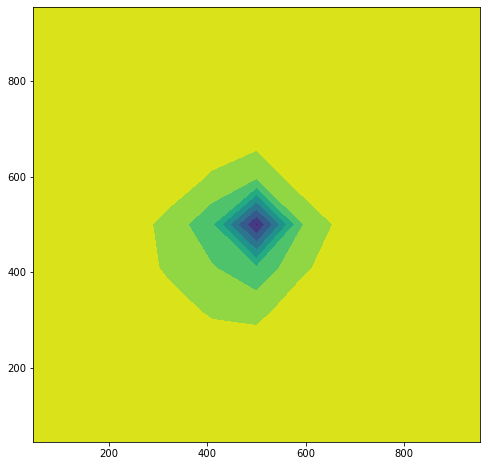

In [3]:
# Dynamic Heatmap of the pressure simulation with 20 iterations
%matplotlib inline
Pn=np.full(((Nt//20),N,N),0,dtype=np.float64)
for l in range(0,(Nt//20)):
    for i in range(0,N):
        for j in range(0,N):
            if l==0:
                Pn[l,i,j]=P[1,i,j]
            elif l==1:
                Pn[l,i,j]=P[5*l,i,j]
            else:
                Pn[l,i,j]=P[10*(l-1),i,j]
fig=plt.figure(figsize=(8,8))
plt.style.use('default')
for i in tqdm(range(0,(Nt//20))):
    time.sleep(1)
    plt.contourf(X,Y,P[i])
    fig.canvas.draw()
    fig.canvas.flush_events()